Features and Terminology:
In stock trading, the high and low refer to the maximum and minimum prices in a given time period. Open and close are the prices at which a stock began and ended trading in the same period. Volume is the total amount of trading activity. Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [39]:
df = pd.read_csv('yahoo_stock.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [40]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


High


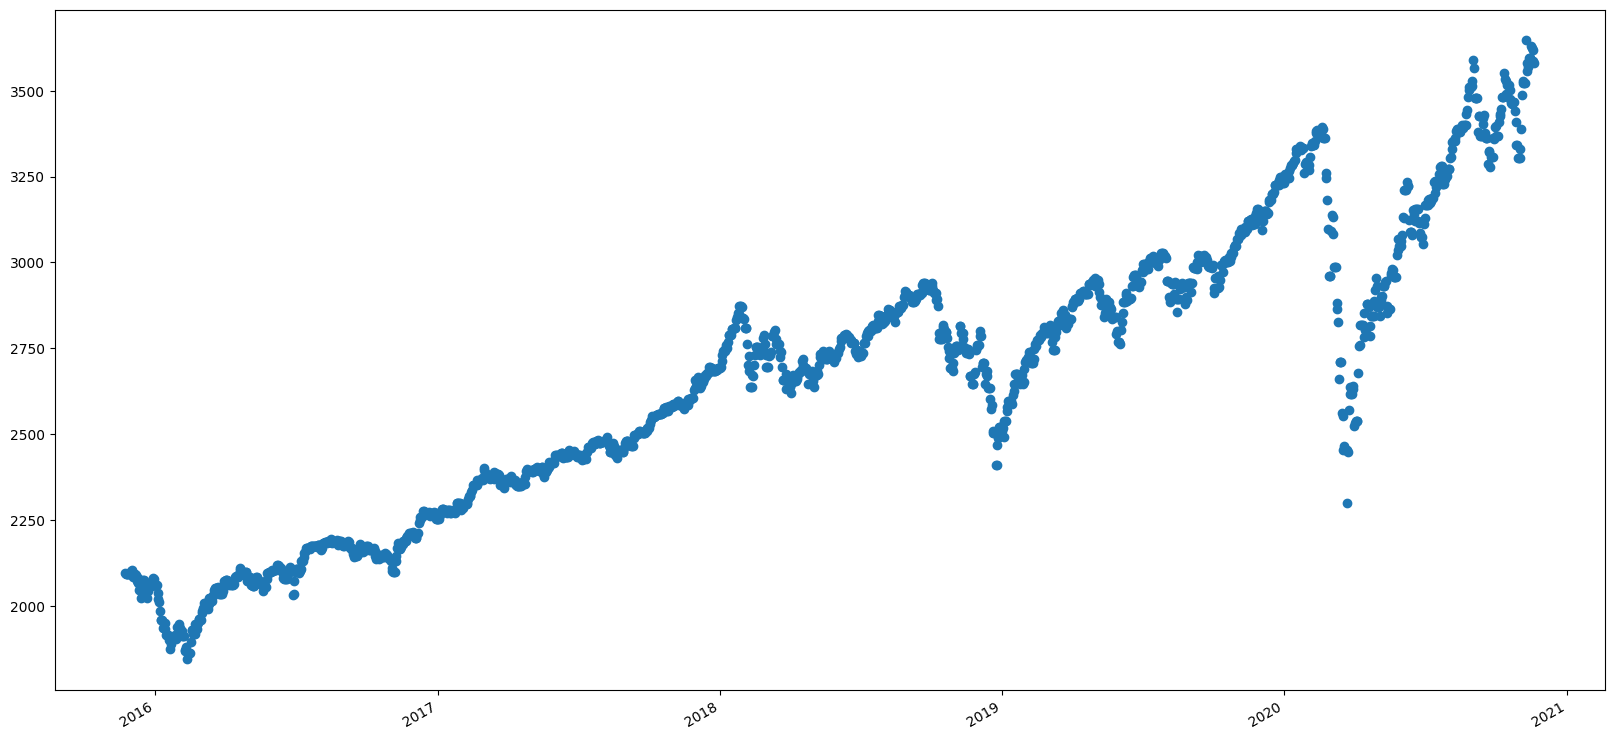

In [41]:
#df.plot(x='Date',y='High')

labels = df.columns.values
labels = labels[1:]

df['Date'] = pd.to_datetime(df['Date'])

years = df['Date'].dt.year.unique()

for label in labels:
    print(label)
    plt.figure(figsize=(20,10))
    plt.scatter(df['Date'],df[label])
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()
    plt.show()
    break

In [42]:
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', extrapolate_trend='freq')
    
    return result_mul, result_add

def plot(result_mul, result_add):

    fig = px.line(title='Multiplicative Decomposition')
    fig.add_scatter(x=result_mul.trend.index, y=result_mul.trend, mode='lines', name='Trend')
    fig.add_scatter(x=result_mul.seasonal.index, y=result_mul.seasonal, mode='lines', name='Seasonal')
    fig.add_scatter(x=result_mul.resid.index, y=result_mul.resid, mode='lines', name='Residual')
    
    fig.update_layout(xaxis_title='Date', yaxis_title='Value')
    fig.show()
    
    fig = px.line(title='Additive Decomposition')
    fig.add_scatter(x=result_add.trend.index, y=result_add.trend, mode='lines', name='Trend')
    fig.add_scatter(x=result_add.seasonal.index, y=result_add.seasonal, mode='lines', name='Seasonal')
    fig.add_scatter(x=result_add.resid.index, y=result_add.resid, mode='lines', name='Residual')
    
    fig.update_layout(xaxis_title='Date', yaxis_title='Value')
    fig.show()

In [43]:
df = pd.read_csv('yahoo_stock.csv', parse_dates = ['Date'], index_col = 'Date')
#result_mul, result_add = seasonal_decomposition(df, 'High')
#plot(result_mul, result_add)

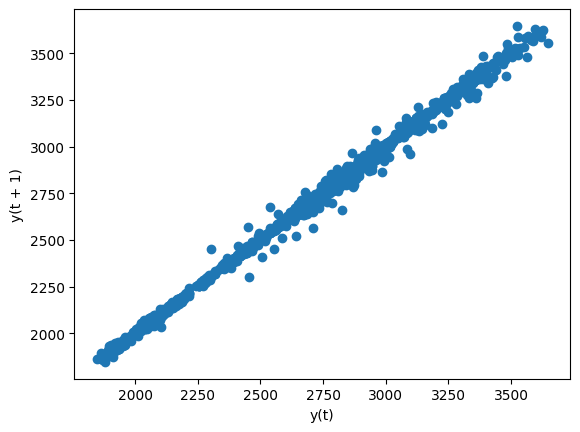

In [44]:
for i in range(1,2):
    pd.plotting.lag_plot(df['High'],lag=i)
    plt.show()

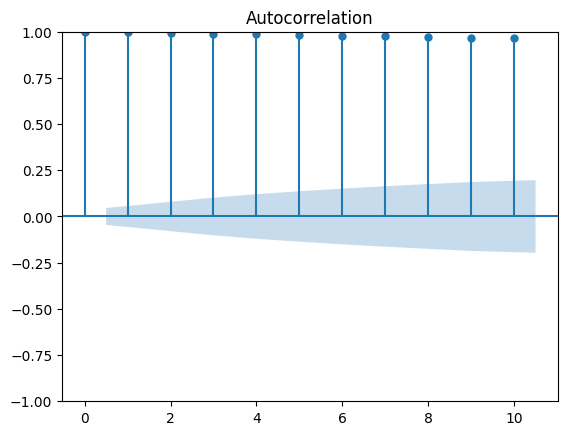

In [45]:
acf= sm.tsa.acf(df['High'])
fig = tsaplots.plot_acf(df['High'], lags=10)
plt.show()

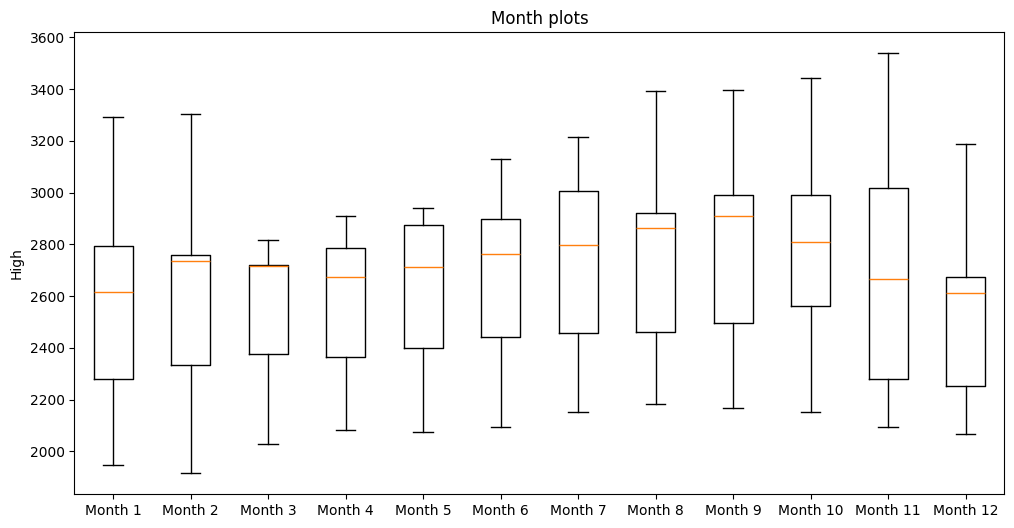

In [55]:
monthly_data = df.resample('M').mean()

# Create a single boxplot with separate boxes for each month
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare the data for each month
data_boxplots = [group['High'].values for month, group in monthly_data.groupby(monthly_data.index.month)]

# Create the boxplot
ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel('High')
ax.set_title('Month plots')

plt.show()


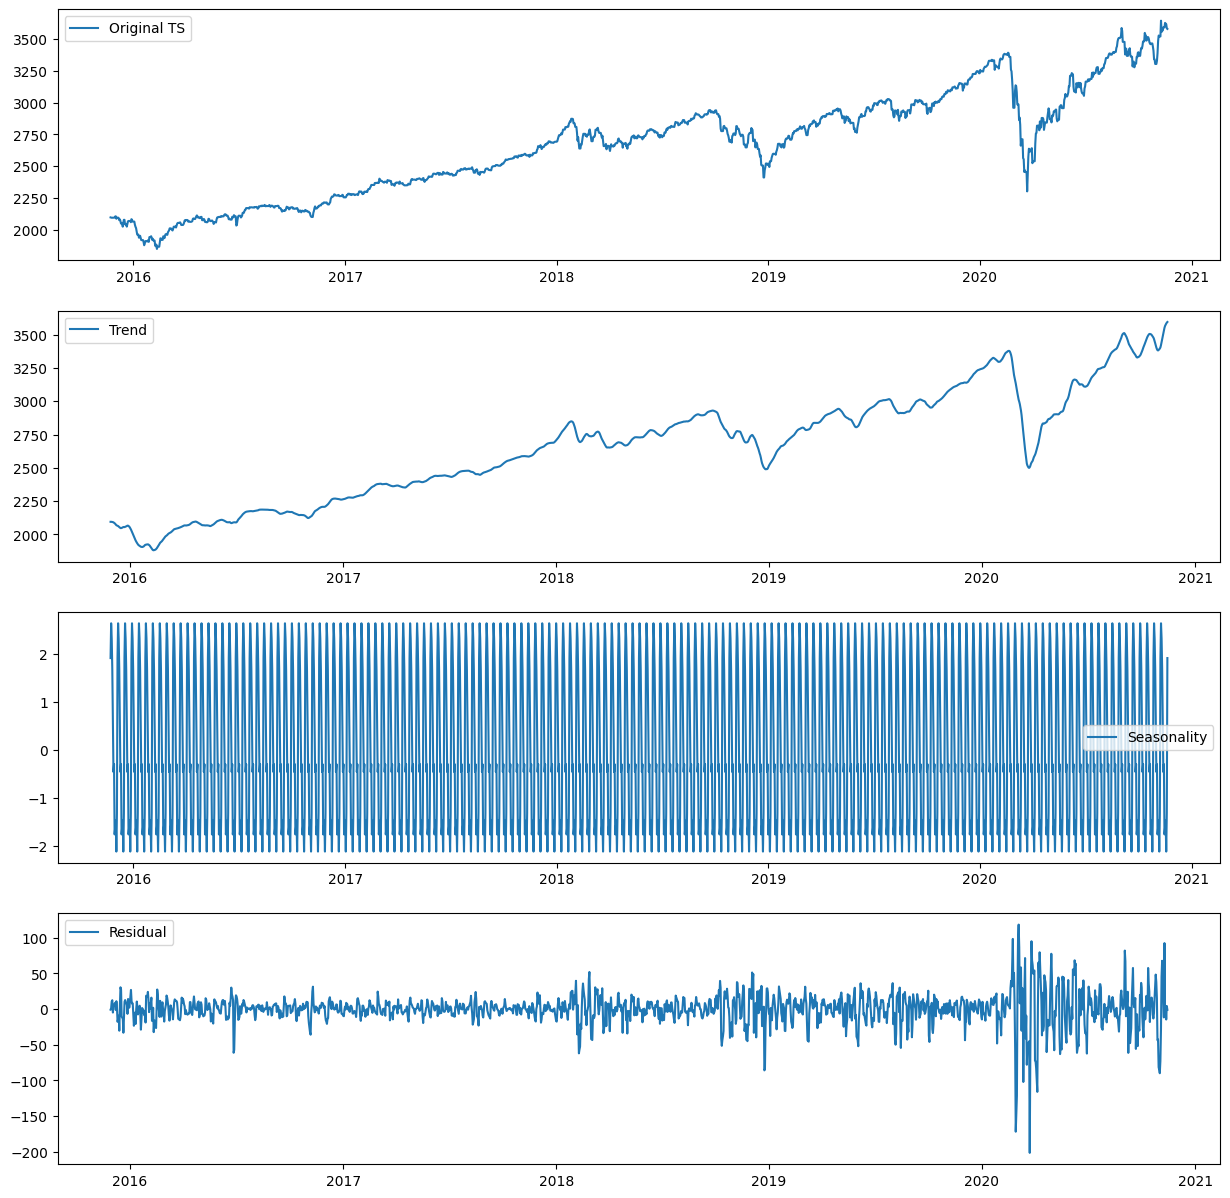

In [46]:
decompose_add=seasonal_decompose(df['High'], model='additive', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')